In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [2]:
df = pd.read_csv('selected_data.csv')

In [4]:
print("Data shape:", df.shape)

Data shape: (21887, 9)


In [5]:
print("Columns:", df.columns)

Columns: Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')


In [6]:
print(df.head())

  symbol        date   open   high    low  close  close_adjusted    volume  \
0      A  1999-11-18  45.50  50.00  40.00  44.00         29.6303  44739900   
1      A  1999-11-19  42.94  43.00  39.81  40.38         27.1926  10897100   
2      A  1999-11-22  41.31  44.00  40.06  44.00         29.6303   4705200   
3      A  1999-11-23  42.50  43.63  40.25  40.25         27.1050   4274400   
4      A  1999-11-24  40.13  41.94  40.00  41.06         27.6505   3464400   

   split_coefficient  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21887 entries, 0 to 21886
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symbol             21887 non-null  object 
 1   date               21887 non-null  object 
 2   open               21887 non-null  float64
 3   high               21887 non-null  float64
 4   low                21887 non-null  float64
 5   close              21887 non-null  float64
 6   close_adjusted     21887 non-null  float64
 7   volume             21887 non-null  int64  
 8   split_coefficient  21887 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.5+ MB
None


In [8]:
print(df.describe())

               open          high           low         close  close_adjusted  \
count  21887.000000  21887.000000  21887.000000  21887.000000    21887.000000   
mean      32.582640     33.202068     31.964162     32.601101       25.572243   
std       34.649756     35.713518     33.648852     34.699771       21.984339   
min        0.000000      0.000000      0.000000      0.340000        0.340000   
25%       10.380000     10.530000     10.210000     10.370000        8.839500   
50%       27.750000     28.230000     27.310000     27.720000       21.760000   
75%       41.455000     42.050000     40.905000     41.480000       37.090000   
max      464.500000    500.100000    442.000000    475.000000      138.130000   

             volume  split_coefficient  
count  2.188700e+04       21887.000000  
mean   8.487579e+06           1.000183  
std    1.504331e+07           0.013518  
min    0.000000e+00           1.000000  
25%    4.583370e+05           1.000000  
50%    3.418100e+06     

In [9]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 symbol               0
date                 0
open                 0
high                 0
low                  0
close                0
close_adjusted       0
volume               0
split_coefficient    0
dtype: int64


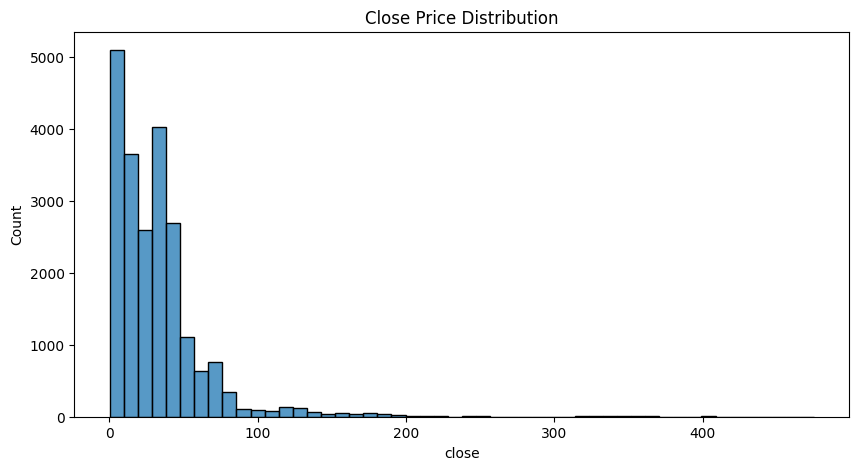

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(df['close'], bins=50)
plt.title('Close Price Distribution')
plt.show()

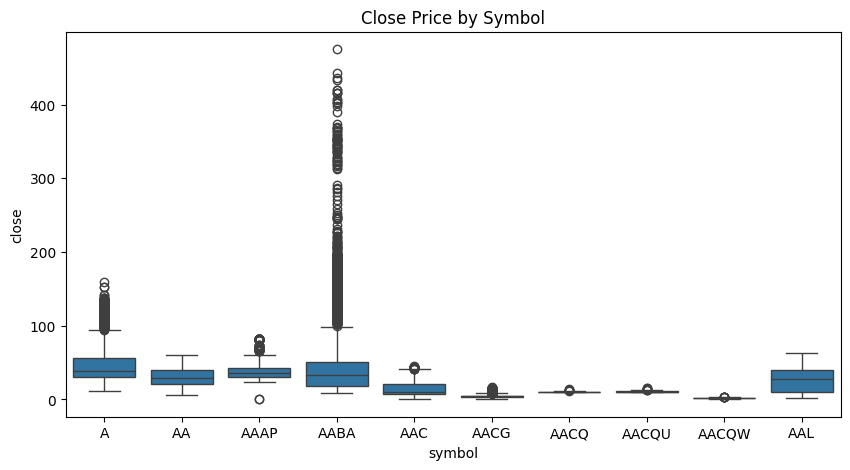

In [11]:
plt.figure(figsize=(10,5))
sns.boxplot(x='symbol', y='close', data=df)
plt.title('Close Price by Symbol')
plt.show()

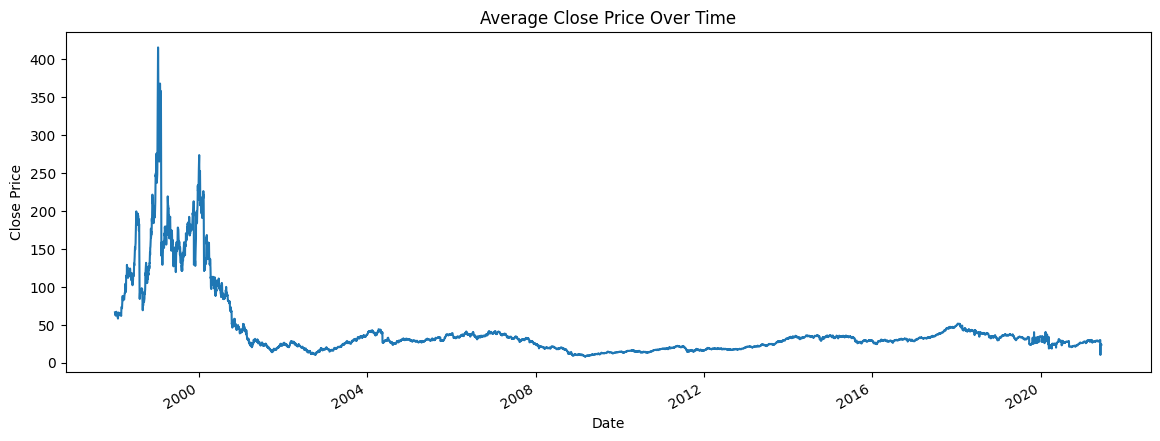

In [12]:
plt.figure(figsize=(14,5))
df['date'] = pd.to_datetime(df['date'])
df.groupby('date')['close'].mean().plot()
plt.title('Average Close Price Over Time')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

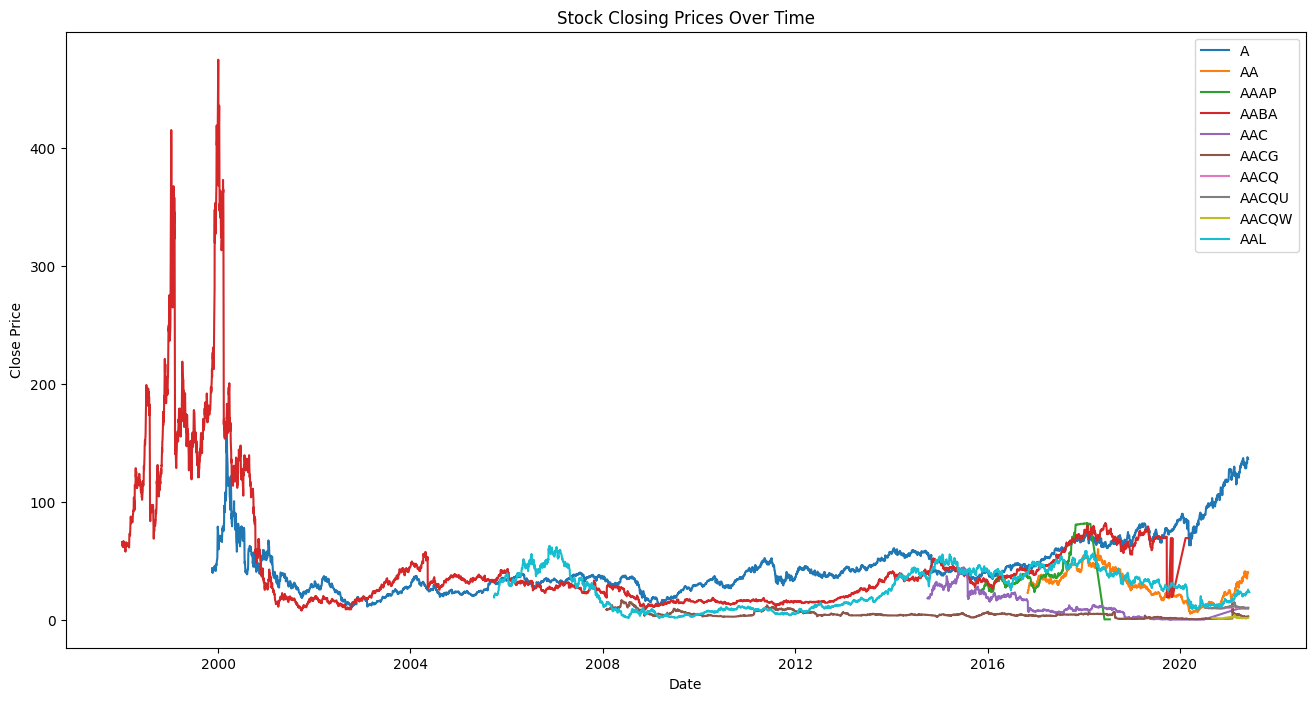

In [17]:
# Price Change Over Time for Each Stock
plt.figure(figsize=(16, 8))
for symbol in df['symbol'].unique():
    symbol_data = df[df['symbol'] == symbol]
    plt.plot(symbol_data['date'], symbol_data['close'], label=symbol)
plt.legend()
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

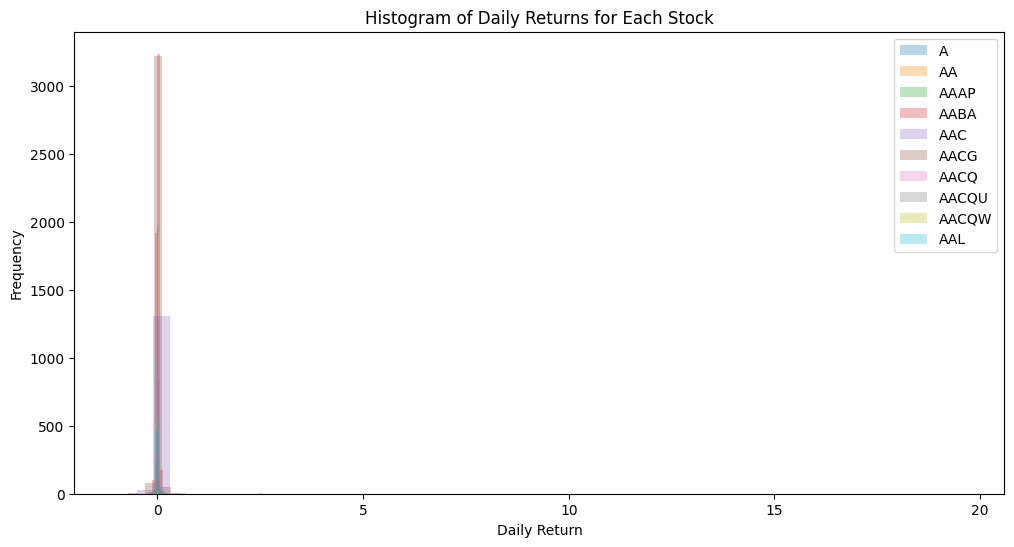

In [16]:
# Daily Returns
df['daily_return'] = df.groupby('symbol')['close'].pct_change()
plt.figure(figsize=(12,6))
for symbol in df['symbol'].unique():
    symbol_data = df[df['symbol'] == symbol]
    plt.hist(symbol_data['daily_return'].dropna(), bins=50, alpha=0.3, label=symbol)
plt.legend()
plt.title('Histogram of Daily Returns for Each Stock')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

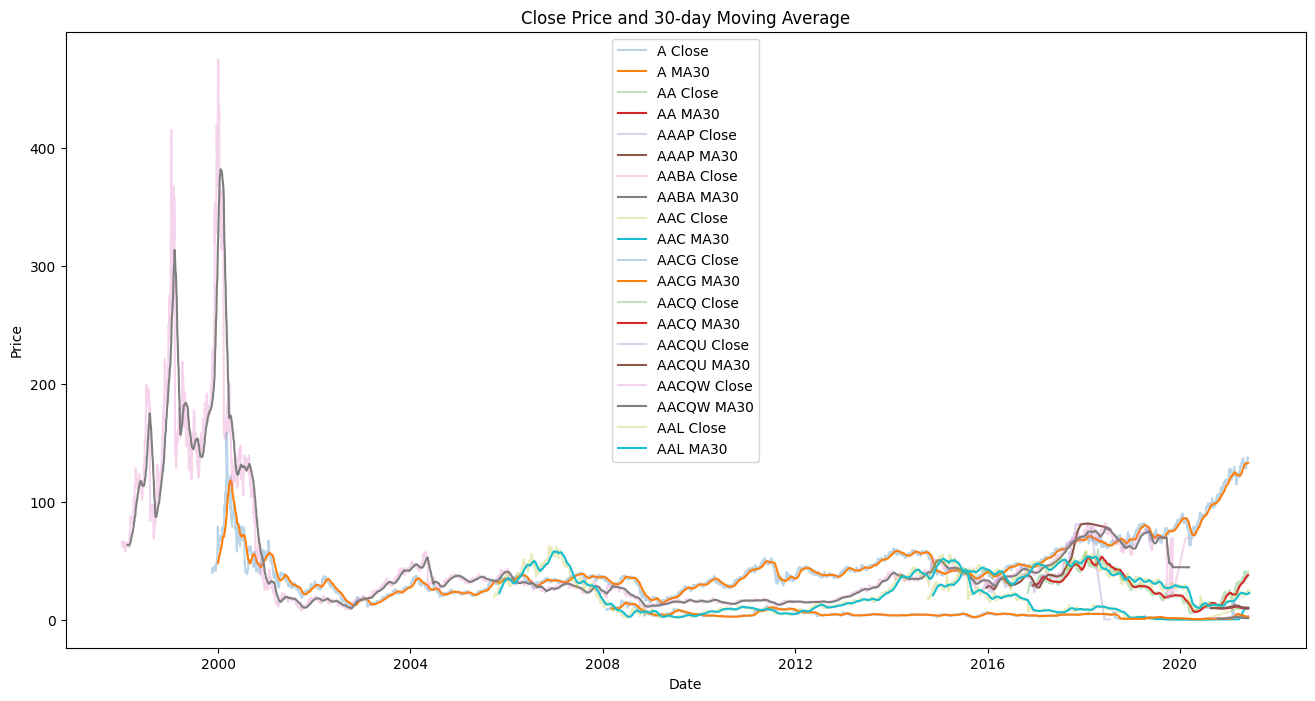

In [19]:
df = df.dropna() 

In [20]:
le = LabelEncoder()
df['symbol_enc'] = le.fit_transform(df['symbol'])

In [22]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

In [24]:
exclude_cols = ['date', 'close_adj', 'symbol']
features = [col for col in df.columns if col not in exclude_cols + ['close']]
X = df[features]
y = df['close']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
models = {
    "Linear": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror'),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42)
}

In [28]:
results = []

In [33]:
for name, model in models.items():
    if name in ['SVR', 'KNN']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.4f}")
    results.append({'Model': name, 'R2': r2, 'RMSE': rmse})

Linear: R2=0.9986, RMSE=1.3010
DecisionTree: R2=0.9987, RMSE=1.2376
RandomForest: R2=0.9994, RMSE=0.8419
SVR: R2=0.7500, RMSE=17.4288
KNN: R2=0.9939, RMSE=2.7253
XGBoost: R2=0.9971, RMSE=1.8785
AdaBoost: R2=0.9505, RMSE=7.7543


In [34]:
results_df = pd.DataFrame(results)
print('\n', results_df)


           Model        R2       RMSE
0        Linear  0.998607   1.300952
1  DecisionTree  0.998739   1.237562
2  RandomForest  0.999417   0.841869
3           SVR  0.749964  17.428835
4           KNN  0.993886   2.725339
5       XGBoost  0.997095   1.878545
6      AdaBoost  0.950506   7.754277


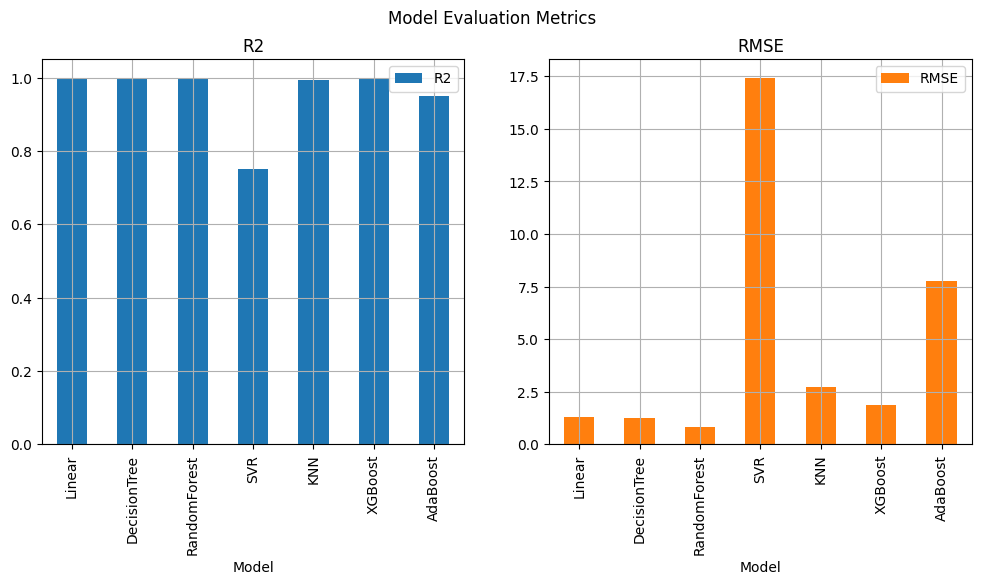

In [35]:
results_df.set_index('Model')[['R2', 'RMSE']].plot(kind='bar', subplots=True, layout=(1,2), figsize=(12,5), grid=True)
plt.suptitle('Model Evaluation Metrics')
plt.show()